In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.plot import plot_summary_stats
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-29 18:15:36,318|INFO|Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}


2024-06-29 18:15:36,456|INFO|Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
2024-06-29 18:15:36,458|INFO|Initializing 64 virtual atoms
2024-06-29 18:15:36,462|INFO|Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-29 18:15:36,463|INFO|Number of pristine atoms is 60
2024-06-29 18:15:36,469|INFO|Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-29 18:15:36,469|INFO|Surface indices are [ 7  8 22 23 37 38 52 53]
2024-06-29 18:15:36,471|INFO|Constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 

      Step     Time          Energy         fmax
BFGS:    0 18:15:36     -467.521881        0.2044
BFGS:    1 18:15:37     -467.525757        0.1803
BFGS:    2 18:15:37     -467.540619        0.0793
BFGS:    3 18:15:37     -467.540924        0.0598
BFGS:    4 18:15:37     -467.541351        0.0059


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(
    **sampling_settings,
    relax=calc_settings["relax_atoms"],
)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

2024-06-29 18:15:37,432|INFO|Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
2024-06-29 18:15:37,433|INFO|There are 60 atoms in pristine slab


      Step     Time          Energy         fmax
BFGS:    0 18:15:37     -467.521881        0.2044
BFGS:    1 18:15:37     -467.525757        0.1803
BFGS:    2 18:15:37     -467.540619        0.0793
BFGS:    3 18:15:37     -467.540924        0.0598
BFGS:    4 18:15:37     -467.541351        0.0059


2024-06-29 18:15:37,986|INFO|Initial energy is 12.471
2024-06-29 18:15:37,987|INFO|Using user specified run folder SrTiO3(001)
2024-06-29 18:15:37,988|INFO|Starting with iteration 0
2024-06-29 18:15:37,989|INFO|Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
2024-06-29 18:15:37,989|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:15:38     -470.504395        3.7932
BFGS:    1 18:15:38     -470.808746        3.1080
BFGS:    2 18:15:38     -471.370392        1.4062
BFGS:    3 18:15:38     -471.420868        0.7292
BFGS:    4 18:15:38     -471.451569        0.4096
BFGS:    5 18:15:38     -471.472046        0.4239
BFGS:    6 18:15:38     -471.477631        0.3832
BFGS:    7 18:15:38     -471.492920        0.4008
BFGS:    8 18:15:38     -471.504059        0.4794
BFGS:    9 18:15:38     -471.516357        0.4667
BFGS:   10 18:15:39     -471.523773        0.3097
BFGS:   11 18:15:39     -471.534821        0.3139
BFGS:   12 18:15:39     -471.541656        0.3127
BFGS:   13 18:15:39     -471.547363        0.4015
BFGS:   14 18:15:39     -471.554779        0.3057
BFGS:   15 18:15:39     -471.561005        0.1980
BFGS:   16 18:15:39     -471.565277        0.1642
BFGS:   17 18:15:39     -471.568024        0.1872
BFGS:   18 18:15:39     -471.569824        0.1381
B

2024-06-29 18:15:48,684|INFO|Optimized structure has Energy = 11.557
2024-06-29 18:15:48,704|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:15:48     -467.146637       30.3018
BFGS:    1 18:15:48     -473.236694       15.3279
BFGS:    2 18:15:49     -477.269073        7.7158
BFGS:    3 18:15:49     -480.028442        5.0073
BFGS:    4 18:15:49     -481.759033        3.5220
BFGS:    5 18:15:49     -482.876556        2.9174
BFGS:    6 18:15:49     -483.909515        2.9523
BFGS:    7 18:15:49     -484.639282        4.0708
BFGS:    8 18:15:49     -485.071198        6.3033
BFGS:    9 18:15:49     -485.860443        4.8294
BFGS:   10 18:15:49     -486.959259        2.5410
BFGS:   11 18:15:49     -487.294769        2.2108
BFGS:   12 18:15:49     -487.566132        1.2213
BFGS:   13 18:15:50     -487.714935        1.4049
BFGS:   14 18:15:50     -487.889191        1.3321
BFGS:   15 18:15:50     -488.064178        1.4231
BFGS:   16 18:15:50     -488.193695        1.2194
BFGS:   17 18:15:50     -488.350342        0.8438
BFGS:   18 18:15:50     -488.440765        0.8017
B

2024-06-29 18:15:58,529|INFO|Optimized structure has Energy = 8.692
2024-06-29 18:15:58,546|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:15:58     -434.021027       96.1589
BFGS:    1 18:15:58     -458.023438       38.2601
BFGS:    2 18:15:58     -468.913818       25.6263
BFGS:    3 18:15:58     -476.174896       16.5134
BFGS:    4 18:15:59     -480.745270        9.5561
BFGS:    5 18:15:59     -483.383453        4.9313
BFGS:    6 18:15:59     -485.033112        3.1239
BFGS:    7 18:15:59     -485.927338        2.8102
BFGS:    8 18:15:59     -486.790131        3.7395
BFGS:    9 18:15:59     -487.795013        3.1483
BFGS:   10 18:15:59     -488.653046        2.0692
BFGS:   11 18:15:59     -489.051025        2.1633
BFGS:   12 18:15:59     -489.442719        2.0242
BFGS:   13 18:15:59     -489.653534        1.5756
BFGS:   14 18:15:59     -489.976044        0.9997
BFGS:   15 18:15:59     -490.067780        0.8307
BFGS:   16 18:16:00     -490.153076        0.7208
BFGS:   17 18:16:00     -490.250854        0.7512
BFGS:   18 18:16:00     -490.315094        0.8941
B

2024-06-29 18:16:08,176|INFO|Optimized structure has Energy = 3.847
2024-06-29 18:16:08,192|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:16:08     -396.093872      129.6546
BFGS:    1 18:16:08     -445.353668       47.4111
BFGS:    2 18:16:08     -462.283569       39.2186
BFGS:    3 18:16:08     -474.799072       18.8603
BFGS:    4 18:16:08     -482.049469       11.3067
BFGS:    5 18:16:08     -486.558441        7.6468
BFGS:    6 18:16:08     -489.412506        5.9543
BFGS:    7 18:16:08     -491.091827        4.8413
BFGS:    8 18:16:09     -492.298340        4.2703
BFGS:    9 18:16:09     -493.421722        4.6263
BFGS:   10 18:16:09     -494.387787        4.0865
BFGS:   11 18:16:09     -495.498749        2.7857
BFGS:   12 18:16:09     -496.284027        1.7855
BFGS:   13 18:16:09     -496.739532        1.6061
BFGS:   14 18:16:09     -497.134979        1.9032
BFGS:   15 18:16:09     -497.466522        2.0199
BFGS:   16 18:16:09     -497.762817        1.4093
BFGS:   17 18:16:09     -497.924561        0.8361
BFGS:   18 18:16:09     -497.997284        0.7106
B

2024-06-29 18:16:18,641|INFO|Optimized structure has Energy = 3.847
2024-06-29 18:16:18,663|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:16:18     -402.045410       95.4898
BFGS:    1 18:16:18     -433.189301       71.1245
BFGS:    2 18:16:18     -449.476471       36.7622
BFGS:    3 18:16:19     -465.726959       23.6845
BFGS:    4 18:16:19     -475.343750       15.4575
BFGS:    5 18:16:19     -481.213989        9.3036
BFGS:    6 18:16:19     -484.495758        4.8854
BFGS:    7 18:16:19     -486.389771        2.9464
BFGS:    8 18:16:19     -487.219574        2.6032
BFGS:    9 18:16:19     -487.873383        2.4272
BFGS:   10 18:16:19     -488.914307        3.4041
BFGS:   11 18:16:19     -489.405640        3.1183
BFGS:   12 18:16:19     -490.125580        1.7549
BFGS:   13 18:16:19     -490.557983        2.1173
BFGS:   14 18:16:20     -491.339752        2.6878
BFGS:   15 18:16:20     -492.072968        2.6910
BFGS:   16 18:16:20     -492.822266        2.4066
BFGS:   17 18:16:20     -493.213959        2.3045
BFGS:   18 18:16:20     -493.525421        1.7674
B

2024-06-29 18:16:29,031|INFO|Optimized structure has Energy = 1.750
2024-06-29 18:16:29,049|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:16:29     -407.330078       97.9115
BFGS:    1 18:16:29     -415.727936      301.4558
BFGS:    2 18:16:29     -451.312897       70.8164
BFGS:    3 18:16:29     -463.496429       37.6044
BFGS:    4 18:16:29     -470.533295       53.9167
BFGS:    5 18:16:29     -474.926025        8.8824
BFGS:    6 18:16:29     -478.299835       10.0964
BFGS:    7 18:16:29     -480.463531       11.9752
BFGS:    8 18:16:29     -480.726349       46.1421
BFGS:    9 18:16:29     -482.792145        5.4615
BFGS:   10 18:16:30     -484.192352       60.3360
BFGS:   11 18:16:30     -484.418243       52.3257
BFGS:   12 18:16:30     -485.873199       29.7640
BFGS:   13 18:16:30     -486.941315       50.0429
BFGS:   14 18:16:30     -488.156769       21.2249
BFGS:   15 18:16:30     -488.840607       41.9658
BFGS:   16 18:16:30     -489.873932       25.5903
BFGS:   17 18:16:30     -490.442841       12.7569
BFGS:   18 18:16:30     -490.802216        7.1435
B

2024-06-29 18:16:39,547|INFO|Optimized structure has Energy = 1.002
2024-06-29 18:16:39,564|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:16:39     -406.018066       98.4582
BFGS:    1 18:16:39     -449.700714       45.4920
BFGS:    2 18:16:39     -470.328735       33.3212
BFGS:    3 18:16:40     -483.083954       20.4459
BFGS:    4 18:16:40     -493.425079       11.3383
BFGS:    5 18:16:40     -499.963165        6.3809
BFGS:    6 18:16:40     -503.879395        4.5463
BFGS:    7 18:16:40     -506.234955        3.2245
BFGS:    8 18:16:40     -507.907959        2.8572
BFGS:    9 18:16:40     -509.417328        3.5879
BFGS:   10 18:16:40     -510.848053        4.0947
BFGS:   11 18:16:41     -512.138916        4.2350
BFGS:   12 18:16:41     -513.533752        4.3454
BFGS:   13 18:16:41     -515.377380        3.6174
BFGS:   14 18:16:41     -516.678406        2.4781
BFGS:   15 18:16:41     -517.547363        2.3670
BFGS:   16 18:16:41     -519.006531        2.6389
BFGS:   17 18:16:41     -519.831848        3.3742
BFGS:   18 18:16:41     -520.337769        2.0686
B

2024-06-29 18:16:51,623|INFO|Optimized structure has Energy = 1.045
2024-06-29 18:16:51,641|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:16:51     -402.641022       99.3152
BFGS:    1 18:16:51     -446.632202       46.7114
BFGS:    2 18:16:51     -465.617889       34.4814
BFGS:    3 18:16:52     -478.097076       21.3150
BFGS:    4 18:16:52     -487.174561       12.9580
BFGS:    5 18:16:52     -493.197144        7.4491
BFGS:    6 18:16:52     -497.127197        4.5269
BFGS:    7 18:16:52     -499.819916        3.3694
BFGS:    8 18:16:52     -501.721924        3.2664
BFGS:    9 18:16:52     -503.357697        3.3800
BFGS:   10 18:16:52     -504.737305        3.4506
BFGS:   11 18:16:52     -505.864838        3.2713
BFGS:   12 18:16:52     -507.172363        3.9655
BFGS:   13 18:16:53     -508.455780        2.8801
BFGS:   14 18:16:53     -508.912476        2.3742
BFGS:   15 18:16:53     -509.542114        1.8883
BFGS:   16 18:16:53     -510.140869        1.8855
BFGS:   17 18:16:53     -510.534332        2.3155
BFGS:   18 18:16:53     -510.974365        1.6049
B

2024-06-29 18:17:02,731|INFO|Optimized structure has Energy = 1.045
2024-06-29 18:17:02,745|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:17:02     -439.177246      100.0985
BFGS:    1 18:17:02     -469.725952       39.2979
BFGS:    2 18:17:03     -485.290863       29.6285
BFGS:    3 18:17:03     -495.498627       18.4297
BFGS:    4 18:17:03     -502.077362       11.0564
BFGS:    5 18:17:03     -505.801544        6.1540
BFGS:    6 18:17:03     -508.125519        3.8386
BFGS:    7 18:17:03     -509.613129        3.5386
BFGS:    8 18:17:03     -510.917694        3.0794
BFGS:    9 18:17:03     -511.869476        3.3385
BFGS:   10 18:17:03     -512.908203        3.5447
BFGS:   11 18:17:03     -514.285095        4.1925
BFGS:   12 18:17:04     -514.741760        2.1313
BFGS:   13 18:17:04     -515.601318        2.2339
BFGS:   14 18:17:04     -516.301453        1.8512
BFGS:   15 18:17:04     -516.737610        1.6024
BFGS:   16 18:17:04     -517.081726        1.5808
BFGS:   17 18:17:04     -517.470764        1.8314
BFGS:   18 18:17:04     -517.793274        1.5751
B

2024-06-29 18:17:13,520|INFO|Optimized structure has Energy = 1.175
2024-06-29 18:17:13,539|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 18:17:13     -378.587128       97.9231
BFGS:    1 18:17:13     -427.545990       49.9484
BFGS:    2 18:17:13     -459.589874       38.2886
BFGS:    3 18:17:14     -476.789948       26.3265
BFGS:    4 18:17:14     -489.789215       17.2305
BFGS:    5 18:17:14     -498.596283       12.2811
BFGS:    6 18:17:14     -504.921783        8.6672
BFGS:    7 18:17:14     -509.094269        6.3273
BFGS:    8 18:17:14     -511.835938        5.3733
BFGS:    9 18:17:14     -514.166565        5.8308
BFGS:   10 18:17:14     -515.941223        3.7452
BFGS:   11 18:17:14     -517.289795        4.0864
BFGS:   12 18:17:14     -517.882019        7.4697
BFGS:   13 18:17:15     -519.221191        2.4814
BFGS:   14 18:17:15     -520.057434        2.3336
BFGS:   15 18:17:15     -520.535889        2.9797
BFGS:   16 18:17:15     -521.152771        2.7448
BFGS:   17 18:17:15     -521.752136        1.6510
BFGS:   18 18:17:15     -522.146423        1.9801
B

2024-06-29 18:17:23,881|INFO|Optimized structure has Energy = 1.175


Time taken = 106.462 seconds


Plot results

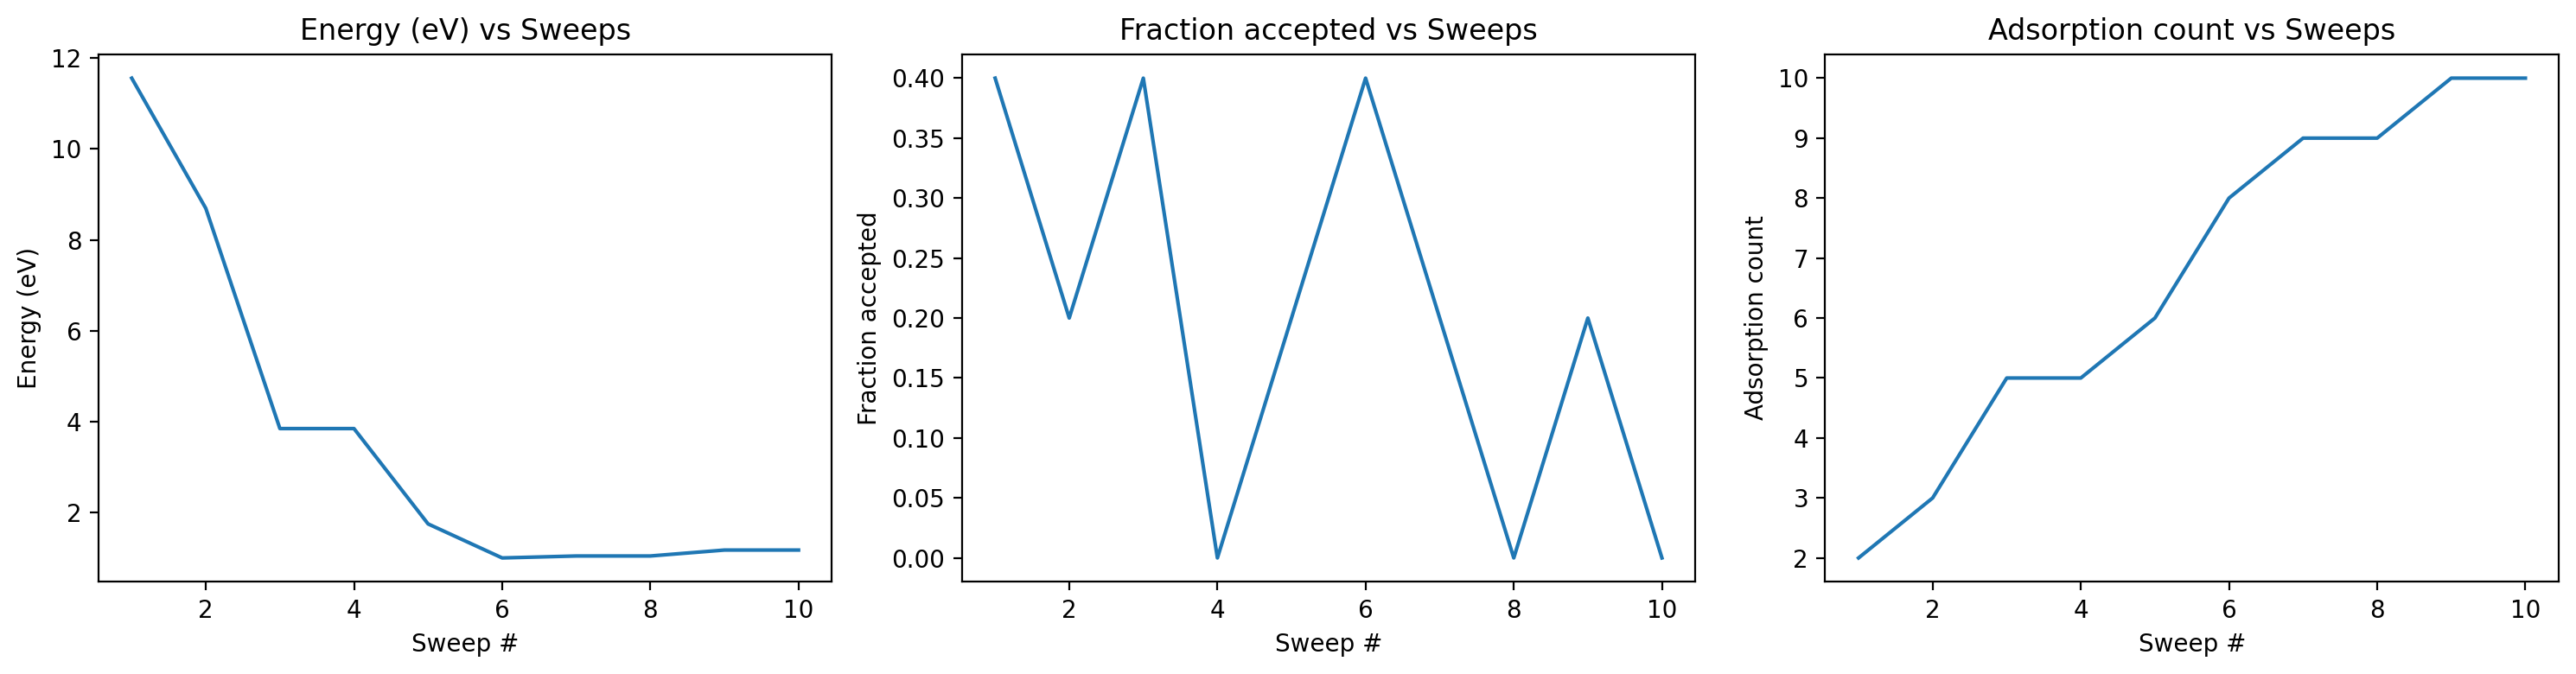

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)